# Analysis of Kaggle's Titanic Dataset
Author: Daniel Pipkin

Data about the passengers aboard the Titanic has become popular in recent years. One of the reasons for this is that the data science site [Kaggle](https://kaggle.com) uses it as an introduction to machine learning.<sup>[1](#Footnotes)</sup>

In [1]:
# Make plots show up in the notebook
%matplotlib inline

# Import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

# Bring an artist's touch to matplotlib's default styles
style.use('seaborn-pastel')

## Previewing Data

Before posing any questions, it is important to take a look at the data. Here are the first couple of rows.

In [2]:
# Import the titanic data
titanic_data = pd.read_csv('titanic-data.csv')

# Print first couple of rows
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Missing Info

Above it looks like three passengers stayed in Cabin number "NaN." This wasn't an actual cabin, these are just missing values. There may be other columns with missing values too.

In [30]:
print("Number of rows: {}".format(len(titanic_data)))
titanic_data.isnull().sum()

Number of rows: 891


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Above we see that *Age*, *Cabin*, and *Embarked* have missing values. *Cabin* is the worst of these with 687 of 891 values missing. These can cause problems when trying to create a predictive model. We may be missing cabin information for passengers because they didn't survive. In this case, a missing cabin number can be a predictor for survival.  
For most of the present analysis, missing values will be included.

Each row contains information about a passenger. Some of these column names can be confusing. Thankfully Kaggle provided context<sup>[2](#Footnotes)</sup>:
* **Survived** only has two values, 0 and 1. One means they survived and zero means they didn't.
* **Pclass** refers to the passenger class (First Class down to steerage).
* **Embarked** Is which port the passenger boarded the Titanic: **S**outhampton, **C**herbourg, or **Q**ueenstown
* **SibSp**, **Parch**, and **Ticket** won't be used in this analysis, but receive their much deserved explanation in the footnotes<sup>[2](#Footnotes)</sup>

## Posing Questions

The two questions we are mainly focusing on:
* What impact did sex, age, class, and cabin location have on chances of survival?
* Was ticket price based on more than passenger class, e.g. did the port of embarkation play a role?

This analysis will rely on:
1. Observed differences in proportion of survivors among groups, and
2. Differences in ticket price among groups  
This will give an overall picture of what factors may have contributed to passengers' price and survival. It will not, however, have enough rigor to imply *how much* impact a certain factor had, or even if those factors had causal effects. I will try to make a distinction without being too stuffy about it.

#### Remarks about the data cleaning process

In each step of the analysis, the data is prepared through a series of transformations with annotations using a process called "method chaining". I find this process easy to follow because, as Tom Augspurger put it:
>Code is read more often than it is written. *(...)* having the story of raw data to results be told as clearly as possible will save you time.<sup>[2](#Footnotes)</sup>

## Part I. Survivors

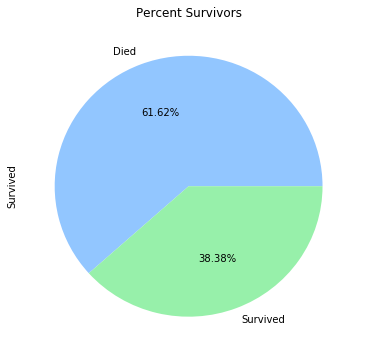

In [3]:
(titanic_data['Survived'].value_counts()                     # Count how many survived
                         .rename({0: 'Died', 1: 'Survived'}) # Rename indicies
                         .plot(kind='pie', figsize=(6, 6),
                               autopct='%.2f%%'))            # Show percents
plt.title('Percent Survivors')
plt.savefig('figures/per_survivors.png')

### "I'll never let go, Jack!"

So what factors did contribute to the survival of some passengers? The one thing I remember from Titanic is that Jack dies and Rose lives. (That, and Leonardo Decaprio toasting like [he does in every movie](http://www.vulture.com/2013/06/gif-history-of-leo-dicaprio-raising-glasses.html)). Let's use this as a starting point.

In [4]:
gender_survived_counts = (titanic_data.loc[titanic_data['Survived'] == 1, 'Sex'] # Select gender of just the survivors
                                      .value_counts())                           # Get the counts of each gender
print(gender_survived_counts)

female    233
male      109
Name: Sex, dtype: int64


Wow! More than twice as many women survived as men. It's much easier to notice those types of relationships in a chart, though. Take a look.

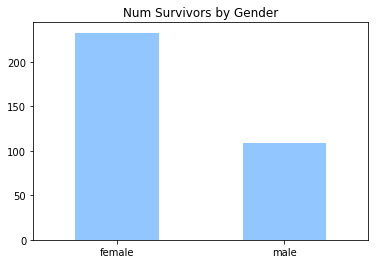

In [5]:
gender_survived_counts.plot(kind='bar', rot=0)     # Rotate the labels to make them easy to read.
plt.title('Num Survivors by Gender')
plt.savefig('figures/num_survivors_gender.png') # To track changes in version control, all charts will be saved

But this might be deceptive. Maybe there were just more women on the Titanic to begin with. Let's get those exact counts along with the chart this time.

In [6]:
def pipe_print(x):
    '''Prints *and* returns data
    This is useful for printing out exact numbers before charting
    '''
    print(x)
    return x

female    314
male      577
Name: Sex, dtype: int64


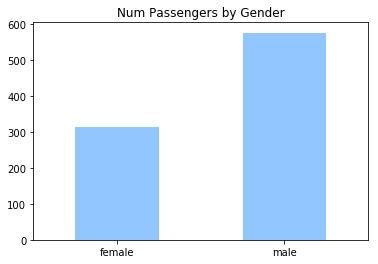

In [7]:
(titanic_data['Sex'].value_counts()  # Count *all* passengers by gender
                    .sort_index()     # Sort for consistent order of bars
                    .pipe(pipe_print) # Print the exact counts
                    .plot(kind='bar', rot=0))
plt.title('Num Passengers by Gender')
plt.savefig('figures/num_gender.png')

On the contrary, men grossly outnumbered women. There is a way to take this into account while at the same time comparing survivors. Getting the *proportion* of those who survived in each group will "normalize" the data for a better comparison. From now on, we'll just use this approach to compare different groups of passengers.

In [8]:
# This will be used a lot.
def percent_survived(group, df=titanic_data):
    '''Returns a series of percentages of survivors
    of each `group`
    '''
    return (pd.crosstab(df[group], df['Survived'],
                        normalize=0) # Make conditional frequency table
              .loc[:, 1])            # Get percentage of just the survivors ('Survived' == 1)

Sex
female    0.742038
male      0.188908
Name: 1, dtype: float64


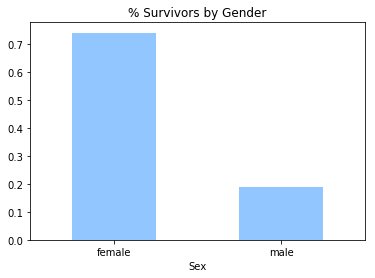

In [9]:
(percent_survived('Sex').pipe(pipe_print) # Print percent of each gender that survived
                        .plot(kind='bar', rot='0'))
plt.title('% Survivors by Gender')
plt.savefig('figures/per_survivors_gender.png')

What does this tell us? 233 out of 314 women from our dataset survived. That means that, like the chart shows, Rose had a 74% chance of survival. Jack only had a 19% chance of getting out of there alive. Truly, theirs was a love that was never meant to be.

### "Women and children first"

Not all male passengers were the same age as Jack, though. There were also children aboard. It is useful to consider these travelers as separate from men and women when it comes to survival. Male children would have a spot on the lifeboats and adult females may be more willing to give their life for that of a child. Some rearrangement of the data can show us the difference in those groups.

In [10]:
def to_mwch(df):
    '''Returns whether a passenger is a child
    and if not, just returns the gender of the passenger'''
    
    # I figure once someone hits their teens,
    # they aren't a child anymore. 
    if df['Age'] < 14:
        return 'child'
    else:
        return df['Sex'] # Missing age values are also included here

MWCh
child     0.591549
female    0.757143
male      0.162963
Name: 1, dtype: float64


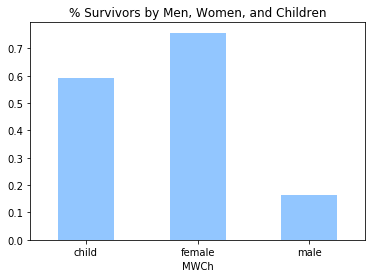

In [11]:
(titanic_data.assign(MWCh=lambda x:                   # Set a Man, Woman, Child column
                            x.apply(to_mwch, axis=1)) # using the above function
            .pipe((percent_survived, 'df'), 'MWCh')   # Get percent of survivors of each group
            .pipe(pipe_print)                         # Print exact values
            .plot(kind='bar', rot='0'))

plt.title('% Survivors by Men, Women, and Children')
plt.savefig('figures/per_survivors_mwch.png')

It looks like those under the age of 14 had a good chance of getting off the ship, but adult women were still better off. This might be related to a child's sensitivity to cold temperatures, and would be a good thing to look out for when reading individual accounts. The 177 passengers for which we had no age are grouped into gender here. Ideally, only adults have unknown ages, but we can't be sure why the values are missing. The hope is that missing age values for children are randomly missing. That way, the proportion of children that survived would be about the same.

### Stay classy 1912
> Woman: I didn't know we had a king!  I thought we were autonomous collective.  
> Dennis: You're fooling yourself!  We're living in a dictatorship!  A self-perpetuating autocracy in which the working **classes**--  
> Woman: There you go, bringing **class** into it again...  
> Man:	That's what it's all about!

The Titanic [Wikipedia article](https://en.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic) discusses a little bit about the socio-economic diversity of the Titanic passengers. This is what their breakdown looks like.

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: 1, dtype: float64


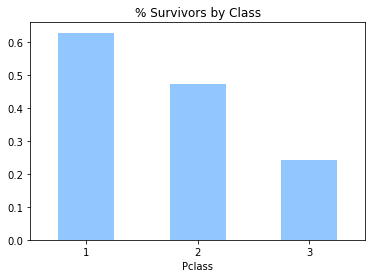

In [12]:
(percent_survived('Pclass').pipe(pipe_print)
                           .plot(kind='bar', rot=0)) # Plot the percent survivors for each Class
plt.title('% Survivors by Class')
plt.savefig('figures/per_survivors_class.png')

Woah, that actually looks pretty classist. It is easy to imagine the first class passengers being given preference while those poor lower class people had to wait for the last lifeboats. After some investigation, I discovered the truth. It wasn't this "self perpetuating autocracy" squashing the lower class. The steerage passengers just had a harder time getting up to the lifeboats.<sup>[2](#Footnotes)</sup>

### Decks
According to my research then, that observed difference is mostly due to where the passengers were staying. Thankfully, the cabin numbers give us upfront information on where the cabin was located. The first letter of each cabin number was the deck they were staying on, with the lower decks with the later letters. There is also a special deck T, but I'll get back to that.

In [13]:
def to_deck(cabin):
    '''Return the deck letter of
    a given cabin. It is just the first letter
    of the cabin number'''
    
    if pd.isnull(cabin):
        return 'No Info'
    else:
        return cabin[0]

Deck
T          0.000000
A          0.466667
B          0.744681
C          0.593220
D          0.757576
E          0.750000
F          0.615385
G          0.500000
No Info    0.299854
Name: 1, dtype: float64


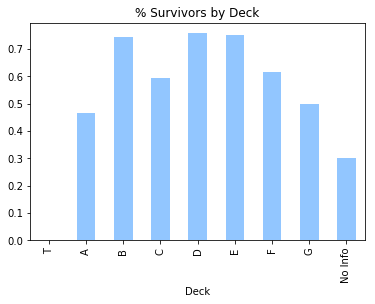

In [14]:
with_decks = titanic_data.assign(Deck=lambda x:            # Set the deck column
                                x['Cabin'].apply(to_deck)) # using the function above

(percent_survived('Deck', with_decks)            # Get percent of survivors of each deck
        .reindex(list('TABCDEFG') + ['No Info']) # Sort so 'No Info' shows last
        .pipe(pipe_print)                        # Print exact values for each percentage
        .plot(kind='bar'))
plt.title('% Survivors by Deck')
plt.savefig('figures/per_survivors_deck.png')

There is a little bit more information to unpack here. It looks like B, D, and E were the best places to be, C and F were so-so, and A and G were the worst places. It makes sense that the people on the lowest deck (G) had a low chance of survival. They were the furthest from the lifeboats. But those staying on deck A had an even lower chance. These people were presumably closest to the lifeboats. Why would they have the lowest chance of survival? After spending way too much time searching and not finding any answers, I leave this explanation as an exercise for the reader.  
There is also a number of passengers for which we have no cabin information. There could be a couple reasons for this. Maybe they weren't assigned a cabin to begin with. But one reason that may help explain the low survival rate is that we can get more information from those who survived. We have the cabin numbers of "those who lived to tell the tale." If the "No Info" group had survived, there might be more info.  
It should be noted that we don't have cabin info for 77% of the passengers. We would expect this "No Info" group to have a similar survival rate to the total population of passengers. Overall, 38% of passengers survived, but only 30% of "No info" passengers survived. We just discussed why they might have a below average survival rate.
You may have also noticed that nobody from deck T survived. T was the very top deck, also known as the "Boat Deck." Here's a list T-deck passengers.

In [15]:
titanic_data[with_decks['Deck'] == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S


As far as we know, Mr. Blackwell was the only passenger staying on the Boat Deck.<sup>[3](#Footnotes)</sup> He was last seen in the smoking room talking to the Captain,<sup>[4](#Footnotes)</sup> who he may have met while he was up there.

---

## Part II. The Price is Right

I like to travel internationally every year. It doesn't always happen, but usually my wife can find the most amazing deals on flights. I don't often think about it, but those on the flight next to us may have paid a completely different price, even though we are both in Economy Class. There could be a number of reasons that the fares varied on the Titanic. Let's start out with some summary statistics.

In [16]:
fares = titanic_data['Fare']
fares.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

Some people got a free ride, half of the passengers got on for less than £15, 75% of people didn't have to pay more than £31, and some sucker paid £512. Wait.... £512! Sometimes it can be hard to put these numbers into perspective. £8 adjusted to 2017 US dollars is about $\$$1080.<sup>[5](#Footnotes)</sup> Double it. Then double that number. Double it again. Now double it three more times. Did you get $\$$69,000? Yeah, me too.  
Those high prices will make it hard to see what the spread of *most* fares are, so let's just take a look at the bottom 90%.

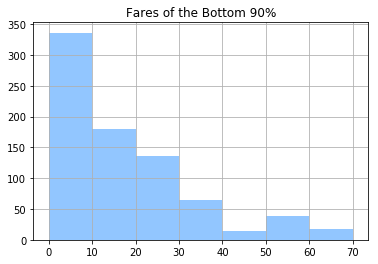

In [17]:
ninetieth = fares.quantile(0.90)   # Get the value of the 90th percentile
bins = np.arange(0, ninetieth, 10) # Create equal sized bins up to the 90th percentile

(titanic_data.loc[titanic_data['Fare'] < ninetieth, 'Fare'] # Only get fares up to 90th percentile
             .hist(bins=bins))
plt.title('Fares of the Bottom 90%')
plt.savefig('figures/fares_bottom_90.png')

### Class is not dismissed

It would make sense that higher class tickets cost more, but we should double check to make sure that's the case 

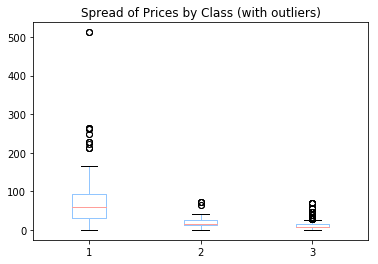

In [18]:
(titanic_data.pivot(columns='Pclass', values='Fare') # Reshape to make Pclass Series of fares
             .plot(kind='box'))
plt.title('Spread of Prices by Class (with outliers)')
plt.savefig('figures/class_price_spread_w_outliers.png')

Ugh, there are those high prices again, making it hard to see the general picture. Here's the same plot without the outliers.

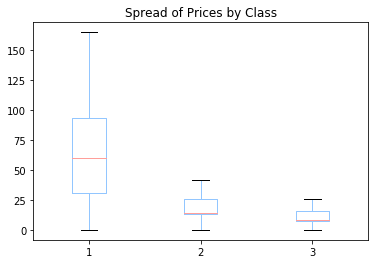

In [19]:
(titanic_data.pivot(columns='Pclass', values='Fare')
             .plot(kind='box', showfliers=False)) # Remove outliers
plt.title('Spread of Prices by Class')
plt.savefig('figures/class_price_spread.png')

There are two things I noticed about these boxplots: the difference in spread and the overlap of prices. The first class tickets vary much more than the others. The variation decreases with class. There is also overlap between the upper fences of the classes with the body of the boxes in the higher class. For example, second class has an upper fence just below £50, but the lower 25% of first class is down around £35~40. Maybe those passengers should have upgraded.

### Deck C is the place to be

Separating the fares by decks may also reveal some information in price differences. 

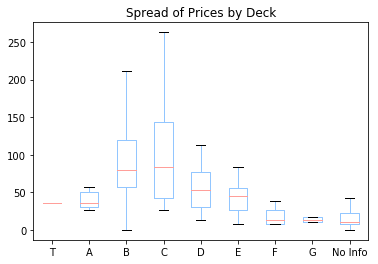

In [20]:
(titanic_data.assign(Deck=lambda x:              # Add deck column using
                    x['Cabin'].apply(to_deck))   # function from above
            .pivot(columns='Deck', values='Fare')
            [list('TABCDEFG') + ['No Info']]     # Sort from top to bottom
            .plot(kind='box', showfliers=False)) # Remove outliers
plt.title('Spread of Prices by Deck')
plt.savefig('figures/deck_price_spread.png')

Most of the price variation comes from the B and C decks. These decks probably housed first class passengers, who seem to be more vulnerable to [information asymmetry](https://en.wikipedia.org/wiki/Information_asymmetry).  
Remember that most of our passengers fell into the "No Info" category, so we can't be certain that this is representative of all the deck prices on the Titanic.

### Now arriving at...

The Titanic stopped at three ports before crossing the Atlantic. One would expect there to be a discount for hopping on later, but sometimes our expectations aren't correct. Let's find out!

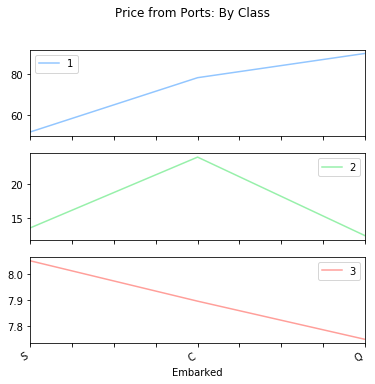

In [21]:
(titanic_data.groupby(['Embarked', 'Pclass']) # We'll want to split the fares up by class as well as embarked
            ['Fare'].median()                 # Get the median for each port of embarkation for each class
            .unstack(level=1)                 # Unstack class to columns
            .reindex(list('SCQ'))             # Reindex to put in chronological order
            .plot(subplots=True, figsize=(6, 6)))
plt.gcf().suptitle('Price from Ports: By Class')
plt.gcf().savefig('figures/price_from_ports.png')

Above I used the median fare at each port for each class. Again, those outliers we saw earlier tend to make our data dirty. Using the median to summarize the fare at each port helps us get an idea of what *most* passengers dealt with. This is by far the strangest data I've seen in this set. More than anything, it seems to indicate that port wasn't a factor in the fare at all. The first class passengers paid **more** for shorter trips and the second class passengers paid a premium to get on in the middle.

## Conclusion

We started this analysis off by looking at the trait differences among the survivors. Gender and age played a big role, as well as socio-economic status. After checking out the differences of the decks, I'm not convinced that explains the variation among groups of different classes.  
On a lighter note, we saw how much the prices can vary, even among the groups of passengers. Splitting it up by deck and port of embarkation didn't help much either.  
While at times it seemed to ask more questions than it answered, I would argue that might be the whole point of doing an analysis. What might seem boring at surface level can contain hidden complexities that fuel our curiousity to learn more. Breaking things down and looking at them from multiple points of view brings an appreciation of nuance that we wouldn't otherwise have.

# Footnotes
1. https://www.kaggle.com/c/titanic
> If you're new to data science and machine learning, or looking for a simple intro to the Kaggle competitions platform, this is the best place to start.
2. https://www.kaggle.com/c/titanic/data

```
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.
```
3.https://tomaugspurger.github.io/method-chaining.html  
4.http://www.bbc.com/news/magazine-17515305  
> Evidence given at the inquiry did suggest that initially some of the gates blocked the way of steerage passengers as stewards waited for instructions and that they were then opened, but only after most of the lifeboats had launched *(...)*  
> None of the evidence presented pointed to any malicious intent to obstruct third class passengers - but rather an oversight caused by unthinking obedience to the regulations, but the results were still deadly.  

5.https://www.encyclopedia-titanica.org/titanic-victim/stephen-weart-blackwell.html  
6.https://www.encyclopedia-titanica.org/cabins.html